In [1]:
import sys, os, glob, h5py
import time, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import TimestreamHelperFunctions as Thf

In [2]:
series    = '20220603_111424'
data_path = os.path.join('/data/USRP_Noise_Scans',series.split('_')[0],series)

In [3]:
## MB Results come from fitting a temperature scan at a specified RF power
MB_fit_vals = np.array([4.24216975, 
                        0.177     ,
                        0.0125    ,
                        4.1e7     ]) ## [ F0 [GHz] , Delta , alpha , Qi0 ]

In [4]:
sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series, verbose=True)
metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)

Line Delay file:  /data/USRP_Noise_Scans/20220603/20220603_111424/USRP_Delay_20220603_111424.h5
VNA scan file:    /data/USRP_Noise_Scans/20220603/20220603_111424/USRP_VNA_20220603_111424.h5
Timestream files: ['/data/USRP_Noise_Scans/20220603/20220603_111424/USRP_Noise_20220603_111424_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220603/20220603_111424/noise_averages_20220603_111424.h5


Will separate data into  6000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
Will convert to quasiparticle basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20220603/20220603_111424/USRP_Noise_20220603_111424_delta0.h5 because override=True!
found 17 pulses
chunk length plugged into welch is 500
chunked data into 6000 timestreams
computed electronics basis
cleaning...
(2, 2767000)
(1, 2767000)
(1, 2767000)
(2, 2767000)
(1, 2767000)
(1, 2767000)
0.01676921937385852
2.1017897100837843
saving clean_data to /data/USRP_Noise_Scans/20220603/20220603_111424/USRP_Noise_20220603_111424_delta0_cleaned.h5 because override=True!
number of chunks used to average is 5534
Converting to resonator basis

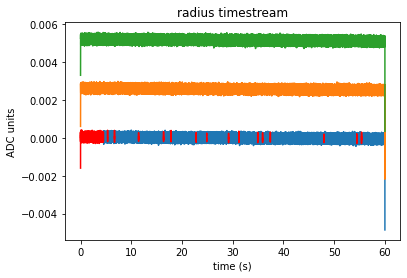

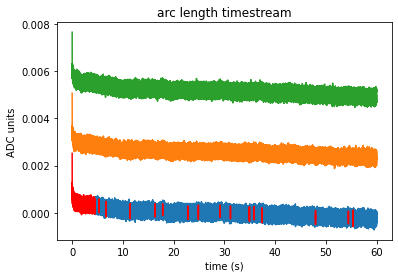

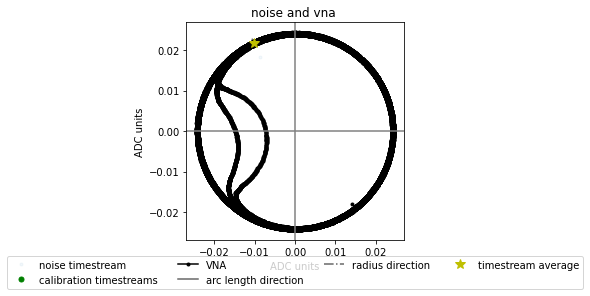

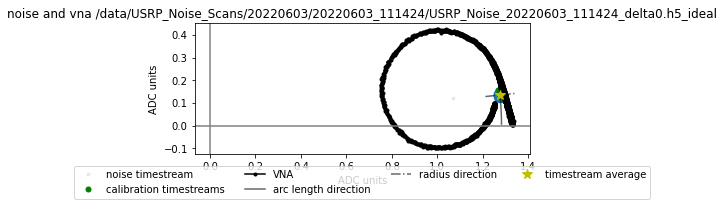

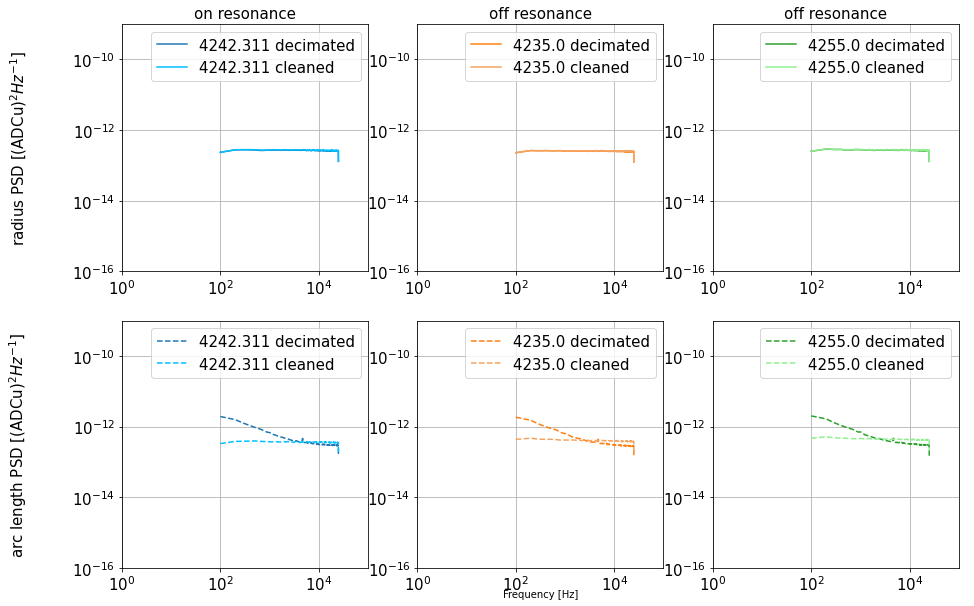

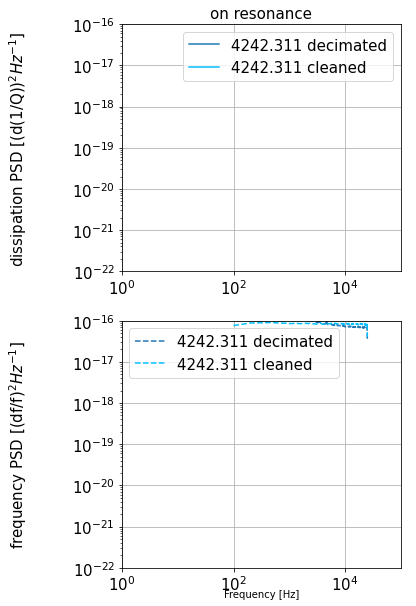

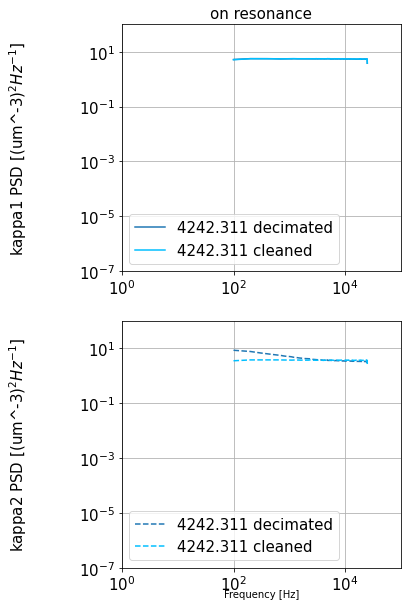

In [5]:
powers, PSDs, res, timestreams = Thf.CleanPSDs(tone_files[0], vna_file, f_transient=0.075,
                                               charFs = avg_frqs,
                                               charZs = avg_S21s,
                                               MBresults = MB_fit_vals)

In [ ]:
print("powers shape:",np.shape(powers))
print("PSDs keys:", PSDs.keys())
print("res kes:", res.keys())
print("timestreams keys:", timestreams.keys())

## Look at cleaned data file

In [ ]:
f_in = tone_files[0].split('.')[0]+"_cleaned.h5"
f    = h5py.File(f_in, 'r')
print("Top-level:", f.keys(), f.attrs.keys())
f.close() ; 

## Look for pulses

In [ ]:
f = h5py.File(tone_files[0], 'r')
print(f['pulses'])
f.close()

In [ ]:
## Pull a list of pulse times from the file
f = h5py.File(tone_files[0], 'r')
p_times = np.array(f['pulses'])
f.close()

## Strip out the pulses from the transient period
p_times = p_times[p_times > timestreams['time'][0]]

In [ ]:
## Create an axis to overlay pulses onto
f_1 = plt.figure()
ax1 = f_1.gca()
ax1.set_xlabel(r"Time [s]")
ax1.set_ylabel(r"Arc length timestream")

ax1.plot(timestreams['time'],timestreams['arc'][:,0])

ylims=ax1.get_ylim()
# for pt in p_times:
#     ax1.plot(pt*np.ones(2),ylims,'r--')
ax1.set_ylim(ylims)
ax1.set_xlim([45.0,55.0])

In [ ]:
## Define a window around the pulse time
pre_win_sec = 100. * 1e-6
pst_win_sec = 500. * 1e-6

## Create an axis to overlay pulses onto
fig = plt.figure()
ax0 = fig.gca()
ax0.set_xlabel(r"Time since trigger [$\mu$s]")
ax0.set_ylabel(r"Arc length timestream")

## What is time resoultion
tstep = (timestreams['time'][1:]-timestreams['time'][:-1])[0]
# print(np.std(timestreams['time'][1:]-timestreams['time'][:-1]))


## Loop over every pulse time
for pt in p_times:
    t_win_min = pt - pre_win_sec
    t_win_max = pt + pst_win_sec
    print(pt,t_win_min,t_win_max,(t_win_max-t_win_min)/tstep)
    
    tvals = timestreams['time'][(timestreams['time']>=t_win_min) * (timestreams['time']<t_win_max)]
    avals = timestreams['arc' ][(timestreams['time']>=t_win_min) * (timestreams['time']<t_win_max)]
    
    ax0.plot((tvals-pt)*1e6, avals, alpha=0.5)

ax0.plot(timestreams['time'],timestreams['arc'][:,0])

# Look at Raw Data -- Cal Delta = 0

In [ ]:
plt.figure()
plt.plot(timesFromRate(rate, len(tone_data[2,:])),logMag(tone_data[2,:]), label="Resonator")
plt.plot(timesFromRate(rate, len(tone_data[0,:])),logMag(tone_data[0,:]), label="Cleaner 1")
plt.plot(timesFromRate(rate, len(tone_data[1,:])),logMag(tone_data[1,:]), label="Cleaner 2")
plt.legend(loc='best')
plt.show()

In [ ]:
plt.figure()
plt.hist(logMag(tone_data[2,:]), bins=np.linspace(start=-2.3,stop=-2.0,num=500), label="Resonator")
plt.hist(logMag(tone_data[0,:]), bins=np.linspace(start=-2.3,stop=-2.0,num=500), label="Cleaner 1")
plt.hist(logMag(tone_data[1,:]), bins=np.linspace(start=-2.3,stop=-2.0,num=500), label="Cleaner 2")
plt.legend(loc='best')
plt.xlabel('LogMag')
plt.show()

In [ ]:
cts, edges = np.histogram(logMag(tone_data[2,:]), bins=np.linspace(start=-2.3,stop=-2.2,num=500))
ctrs = 0.5*(edges[1:]+edges[:-1])
plt.figure()
plt.step(edges[:-1],cts,where='post')

In [ ]:
def gauss(x,a,m,s):
    z = (x-m)/s
    return a * np.exp(-0.5*z*z)

from scipy.optimize import curve_fit

In [ ]:
p0 = [np.max(cts),np.mean(logMag(tone_data[2,:])),np.std(logMag(tone_data[2,:]))]
popt,pcov = curve_fit(gauss,ctrs,cts,p0=p0)
perr = np.sqrt(np.diag(pcov))

plt.figure()
plt.step(edges[:-1],cts,where='post')
plt.plot(ctrs,gauss(ctrs,popt[0],popt[1],popt[2]))
plt.show()

print("Mean:", popt[1], "Stdev:", popt[2])
print("Sig/Mu:", popt[2]/popt[1])

In [ ]:
cts0, edges0 = np.histogram(logMag(tone_data[0,:]), bins=np.linspace(start=-2.1,stop=-2.0,num=500))
ctrs0 = 0.5*(edges0[1:]+edges0[:-1])

p00 = [np.max(cts0),np.mean(logMag(tone_data[0,:])),np.std(logMag(tone_data[0,:]))]
popt0,pcov0 = curve_fit(gauss,ctrs0,cts0,p0=p00)
perr0 = np.sqrt(np.diag(pcov0))

cts1, edges1 = np.histogram(logMag(tone_data[1,:]), bins=np.linspace(start=-2.1,stop=-2.0,num=500))
ctrs1 = 0.5*(edges1[1:]+edges1[:-1])

p01 = [np.max(cts1),np.mean(logMag(tone_data[1,:])),np.std(logMag(tone_data[1,:]))]
popt1,pcov1 = curve_fit(gauss,ctrs1,cts1,p0=p01)
perr1 = np.sqrt(np.diag(pcov1))

plt.figure()
plt.step(edges0[:-1],cts0,where='post')
plt.plot(ctrs0,gauss(ctrs0,popt0[0],popt0[1],popt0[2]))

plt.step(edges1[:-1],cts1,where='post')
plt.plot(ctrs1,gauss(ctrs1,popt1[0],popt1[1],popt1[2]))
plt.show()

print("CLEANING TONE 1")
print("Mean:", popt0[1], "Stdev:", popt0[2])
print("Sig/Mu:", popt0[2]/popt0[1])


print("CLEANING TONE 2")
print("Mean:", popt1[1], "Stdev:", popt1[2])
print("Sig/Mu:", popt1[2]/popt1[1])

In [ ]:
cts0, edges0 = np.histogram(phase(tone_data[0,:]), bins=np.linspace(start=3.5,stop=4.4,num=500))
ctrs0 = 0.5*(edges0[1:]+edges0[:-1])

p00 = [np.max(cts0),np.mean(phase(tone_data[0,:])),np.std(phase(tone_data[0,:]))]
popt0,pcov0 = curve_fit(gauss,ctrs0,cts0,p0=p00)
perr0 = np.sqrt(np.diag(pcov0))

cts1, edges1 = np.histogram(phase(tone_data[1,:]), bins=np.linspace(start=3.5,stop=4.4,num=500))
ctrs1 = 0.5*(edges1[1:]+edges1[:-1])

p01 = [np.max(cts1),np.mean(phase(tone_data[1,:])),np.std(phase(tone_data[1,:]))]
popt1,pcov1 = curve_fit(gauss,ctrs1,cts1,p0=p01)
perr1 = np.sqrt(np.diag(pcov1))

ctsR, edgesR = np.histogram(phase(tone_data[2,:]), bins=np.linspace(start=3.5,stop=4.4,num=500))
ctrsR = 0.5*(edgesR[1:]+edgesR[:-1])

p0R = [np.max(ctsR),np.mean(phase(tone_data[2,:])),np.std(phase(tone_data[2,:]))]
poptR,pcovR = curve_fit(gauss,ctrsR,ctsR,p0=p0R)
perrR = np.sqrt(np.diag(pcovR))

plt.figure()
plt.step(edges0[:-1],cts0,where='post')
plt.plot(ctrs0,gauss(ctrs0,popt0[0],popt0[1],popt0[2]),label="CT1 fit")

plt.step(edges1[:-1],cts1,where='post')
plt.plot(ctrs1,gauss(ctrs1,popt1[0],popt1[1],popt1[2]),label="CT2 fit")

plt.step(edgesR[:-1],ctsR,where='post')
plt.plot(ctrsR,gauss(ctrsR,poptR[0],poptR[1],poptR[2]),label="Res fit")

plt.xlabel('Phase [rad]')
plt.legend(loc='best')
plt.show()

print("RESONANT TONE")
print("Mean:", poptR[1], "Stdev:", poptR[2])
print("Sig/Mu:", poptR[2]/poptR[1])

print("CLEANING TONE 1")
print("Mean:", popt0[1], "Stdev:", popt0[2])
print("Sig/Mu:", popt0[2]/popt0[1])

print("CLEANING TONE 2")
print("Mean:", popt1[1], "Stdev:", popt1[2])
print("Sig/Mu:", popt1[2]/popt1[1])

In [ ]:
plt.figure()
plt.plot(timesFromRate(rate, len(tone_data[2,:])),logMag(tone_data[2,:])-0.5*(logMag(tone_data[0,:])+logMag(tone_data[1,:])), label="Cleaned Resonator")
plt.legend(loc='best')
plt.show()

In [ ]:
def movingAvg(data, winsize):
    if (winsize < 2):
        print("Need a larger window")
        return None
    
    ## Make sure the box is odd sized
    if winsize % 2. == 0:
        halfwin  = winsize/2.
        winsize += 1
    else:
        halfwin  = (winsize-1)/2.
        
    ## Create an output container
    data_avg = np.zeros(len(data)-winsize+1)
    
    for i in np.arange(len(data_avg)):
        data_i = int(i+halfwin)
        i_min  = int(data_i-halfwin)
        i_max  = int(data_i+halfwin+1)
        data_avg[i] = np.mean(data[i_min:i_max])
    
    

In [ ]:
plt.figure()
plt.plot(movingAvg(logMag(tone_data[2,:])-0.5*(logMag(tone_data[0,:])+logMag(tone_data[1,:])),15), label="Cleaned Resonator")
plt.show()